In [83]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import simpy
import queue
import math
from scipy import stats

In [84]:
# Simulation parameters
simulationDuration = 1000  # Total simulation time
df_responseTimes = pd.DataFrame(columns=['time', 'traffic_class', 'response_time', 'burstiness'])
df_lossRates = pd.DataFrame(columns=['time', 'traffic_class', 'loss_rate'])

np.random.seed(10)

In [85]:
# Function to print loss rates periodically
seqno = 0  # Global sequence number for packet identification
periodPrintLR = 10

def print_loss_rate(env, source):
    global df_lossRates
    if source.nb_emissions > 0:  # Avoid division by zero
        df_lossRates.loc[len(df_lossRates)] = {
            'traffic_class': source.ident,
            'time': env.now,
            'loss_rate': source.queue_losses / source.nb_emissions  # Compute loss rate
        }


In [86]:
# Packet class to store packet attributes
class Packet:
    def __init__(self, t, ident, pkt_size):
        global seqno
        seqno += 1
        self.t = t  # Time of packet creation
        self.ident = ident  # Traffic class identifier
        self.pkt_size = pkt_size  # Packet size in bytes
        self.seqno = seqno  # Unique sequence number


In [87]:
# Queue class that simulates infinite buffer queue + server
class QueueClass:
    def __init__(self, env, service_rate, b):
        self.env = env  # Simulation environment
        self.in_service = 0  # Tracks if a packet is in service
        self.queue_capacity = float('inf')  # Infinite queue capacity
        self.service_rate = service_rate * 1e6  # Convert Mbps to bps
        self.burstiness_level = b
        self.buffer = queue.Queue(maxsize=int(1e7))  # Large capacity for approximation
        self.queue_length = 0  # Tracks total queue length
        self.cpterPrintLR = 0  # Counter for printing loss rate

    def service(self):
        if not self.buffer.empty():
            p = self.buffer.get_nowait()
            self.in_service = 1
            service_time = p.pkt_size * 8 / self.service_rate
            yield self.env.timeout(service_time)
            
            # Ensure burstiness is recorded correctly
            df_responseTimes.loc[len(df_responseTimes)] = {
                'time': self.env.now, 
                'traffic_class': p.ident, 
                'response_time': self.env.now - p.t,
                'burstiness': self.burstiness_level  # Ensure burstiness is logged
            }
            del p
            
            if not self.buffer.empty():
                self.env.process(self.service())
            else:
                self.in_service = 0


    def reception(self, source, pkt):
        if self.queue_length + pkt.pkt_size <= self.queue_capacity:
            self.queue_length += pkt.pkt_size
            self.buffer.put(pkt)  # Add packet to queue
            if self.in_service == 0:
                self.env.process(self.service())  # Start processing if idle
                print_loss_rate(self.env,source)
        else:
            source.queue_losses += 1  # Count lost packets
            print_loss_rate(self.env, source)

In [88]:
# Poisson source class to simulate traffic
class PoissonSource:
    def __init__(self, env, rate, queue, ident, pkt_size):
        self.env = env  # Simulation environment
        self.rate = rate  # Packet arrival rate
        self.q = queue  # Reference to queue
        self.ident = ident  # Traffic type identifier
        self.pkt_size = pkt_size  # Packet size in bytes
        self.nb_emissions = 0  # Total packets generated
        self.queue_losses = 0  # Count of dropped packets
        self.cpterPrintLR = 0  # Counter for loss rate printing
        self.action = env.process(self.run())  # Start packet generation
        
    def run(self):
        while self.env.now < simulationDuration:  # Stop packet generation at simulation end
            yield self.env.timeout(np.random.exponential(scale=1/self.rate))
            self.nb_emissions += 1
            if self.env.now < simulationDuration:  # Ensure packet is only sent within time limits
                p = Packet(self.env.now, self.ident, self.pkt_size)
                self.q.reception(self, p)

In [89]:
class BurstSource:
    def __init__(self, env, b, queue, ident, pkt_size, peak_rate):
        self.env = env
        self.b = b  # Burstiness factor
        self.q = queue
        self.ident = ident
        self.pkt_size = pkt_size
        self.peak_rate = peak_rate
        self.nb_emissions = 0
        self.queue_losses = 0
        self.on_rate = 1e3 # Fixed ON period
        self.off_rate = (self.on_rate* self.b)-self.on_rate  # OFF period scales with burstiness
        self.action = env.process(self.run())
        self.is_on = False

    def run(self):
        while self.env.now < simulationDuration:
            self.nb_emissions+=1
            if not self.is_on:
                yield self.env.timeout(np.random.exponential(1/self.off_rate))
                self.is_on = True
            else:
                yield self.env.timeout(np.random.exponential(1/self.on_rate))
                for _ in range(int(self.peak_rate)):
                    if self.env.now < simulationDuration:
                        p = Packet(self.env.now, self.ident, self.pkt_size)
                        self.q.reception(self, p)
                self.is_on = False


In [90]:
def run_experiment(b_values, simulationDuration=simulationDuration):
    results = []
    
    for b in b_values:
        print(f"Running simulation for burstiness b={b}")
        
        # Reset simulation environment
        env = simpy.Environment()
        queue = QueueClass(env, 100,b)  # 100 Mbps server

        # Define traffic sources
        data_source = PoissonSource(env, rate=30, queue=queue, ident='data', pkt_size=np.random.choice([50, 500, 1500], p=[0.4, 0.3, 0.3]))
        voice_source = PoissonSource(env, rate=20, queue=queue, ident='voice', pkt_size=100)
        video_source = BurstSource(env, b, queue=queue, ident='video', pkt_size=1000, peak_rate=5)


        # Run the simulation
        env.run(until=simulationDuration)

        for traffic_class in ['data', 'voice', 'video']:
            subset = df_responseTimes[df_responseTimes['traffic_class'] == traffic_class]
            if not subset.empty:
                mean_rt = subset['response_time'].mean()
                std_rt = subset['response_time'].std()
                ci_rt = stats.norm.interval(0.95, loc=mean_rt, scale=std_rt/np.sqrt(len(subset)))

                results.append({'b': b, 'traffic_class': traffic_class, 'mean_response_time': mean_rt, 'confidence_interval': ci_rt})

    return pd.DataFrame(results)


b_values = [0.5, 1, 2, 5,10]  # Different burstiness values to test
experiment_results = run_experiment(b_values)

# Save results to CSV for further analysis
experiment_results.to_csv("burstiness_results.csv", index=False)
print("Experiment results saved!")

Running simulation for burstiness b=0.5
Running simulation for burstiness b=1
Running simulation for burstiness b=2
Running simulation for burstiness b=5
Running simulation for burstiness b=10
Experiment results saved!


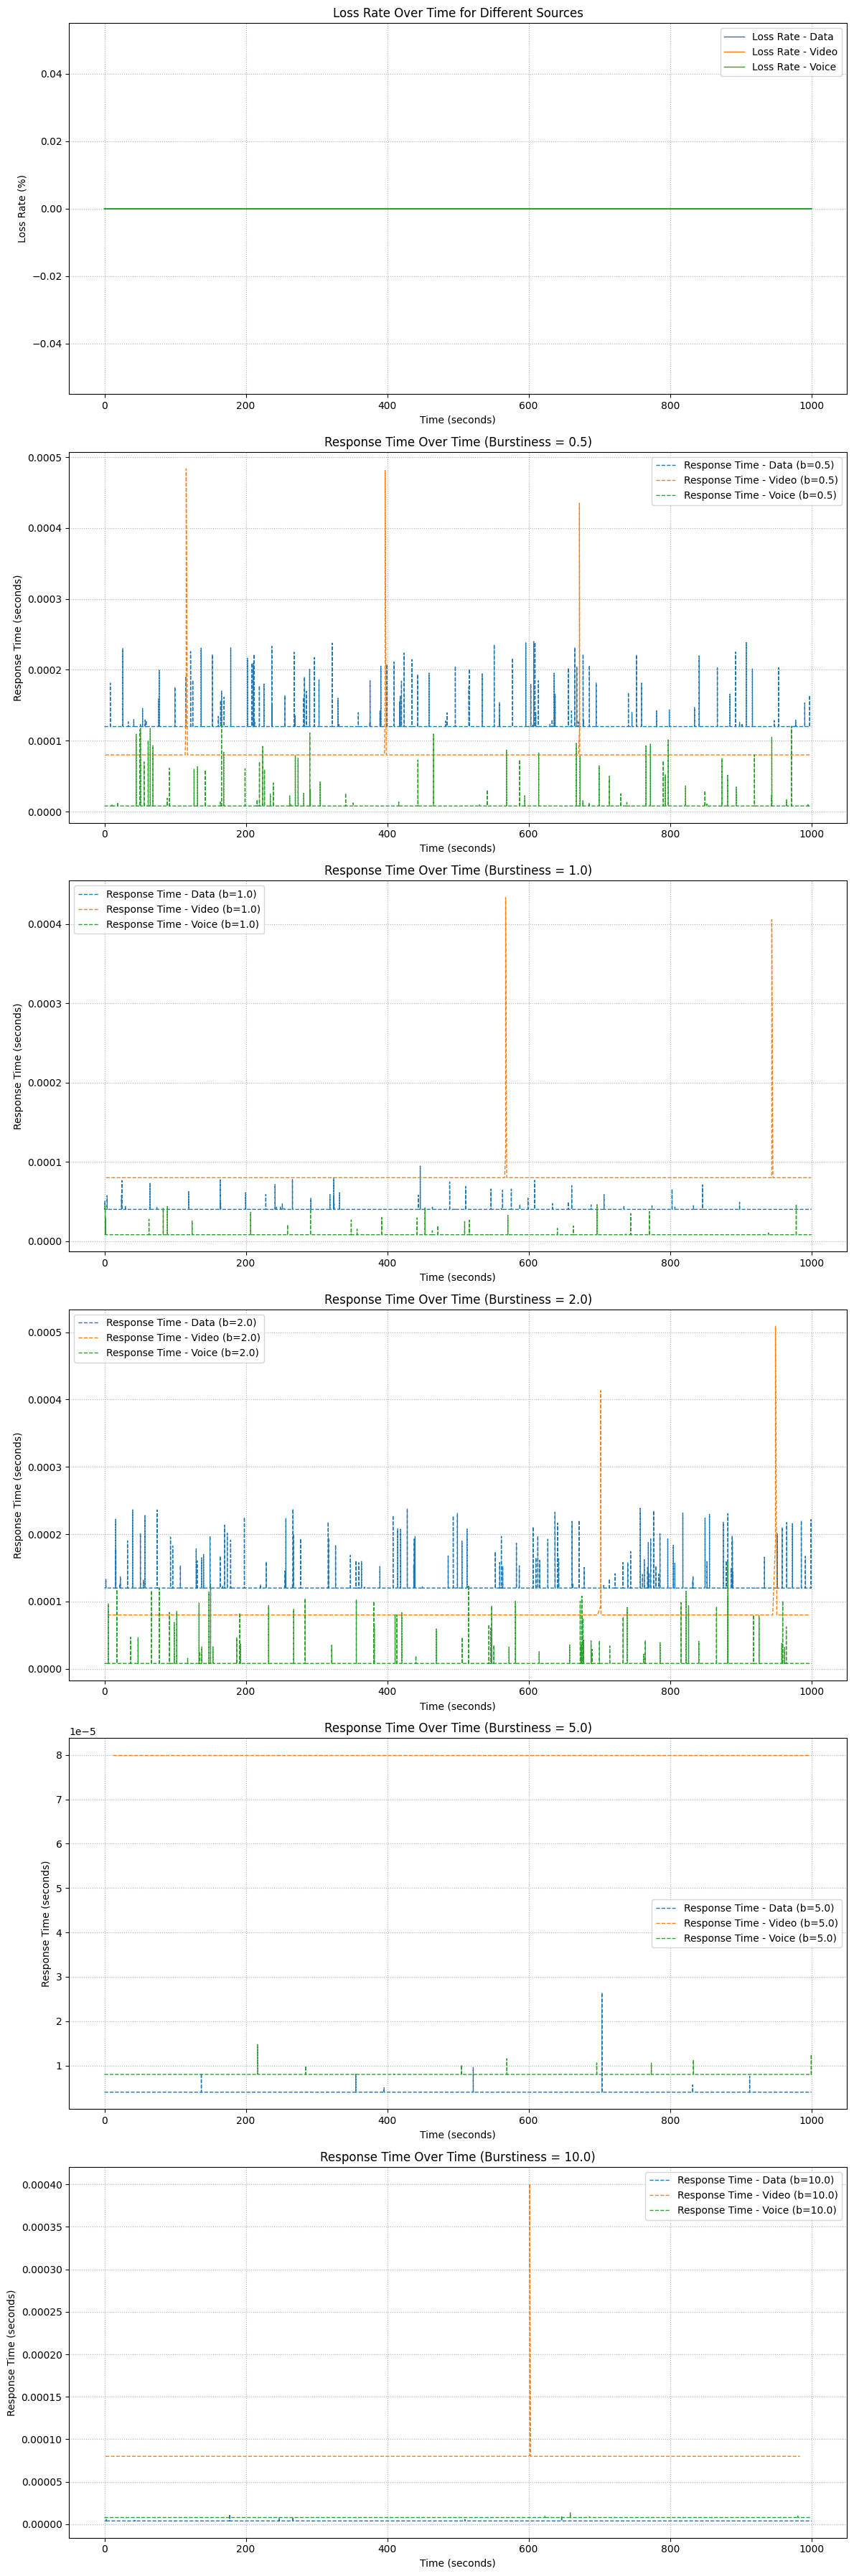

In [91]:
# Get unique burstiness levels from experiment results
b_values = df_responseTimes['burstiness'].dropna().unique()

# Create figure with subplots for loss rate and response time
fig, axs = plt.subplots(len(b_values) + 1, 1, figsize=(12, 6 * (len(b_values) + 1)))

# ---- Loss Rate Plot (First subplot) ----
for traffic_class in ['data', 'video', 'voice']:
    if not df_lossRates[df_lossRates['traffic_class'] == traffic_class].empty:
        axs[0].plot(df_lossRates[df_lossRates['traffic_class'] == traffic_class]['time'],
                    df_lossRates[df_lossRates['traffic_class'] == traffic_class]['loss_rate'],
                    label=f"Loss Rate - {traffic_class.capitalize()}", linewidth=1)

axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Loss Rate (%)")
axs[0].set_title("Loss Rate Over Time for Different Sources")
axs[0].legend()
axs[0].grid(True, linestyle='dotted')

# ---- Response Time Plots for each Burstiness Level ----
for i, b in enumerate(b_values):
    ax = axs[i + 1]  # Offset index since first plot is loss rate

    for traffic_class in ['data', 'video', 'voice']:
        filtered_data = df_responseTimes[(df_responseTimes['traffic_class'] == traffic_class) & (df_responseTimes['burstiness'] == b)]
        if not filtered_data.empty:
            ax.plot(filtered_data['time'], filtered_data['response_time'],
                    label=f"Response Time - {traffic_class.capitalize()} (b={b})", linestyle="dashed", linewidth=1)

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Response Time (seconds)")
    ax.set_title(f"Response Time Over Time (Burstiness = {b})")
    ax.legend()
    ax.grid(True, linestyle='dotted')

plt.tight_layout()
plt.show()


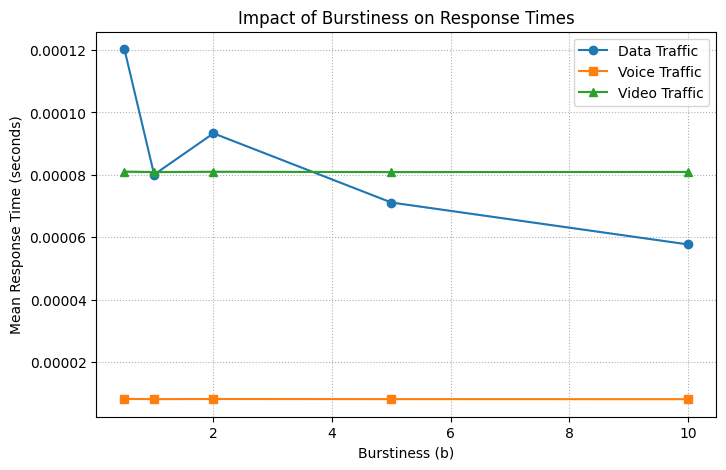

In [92]:
# Load experiment results
experiment_results = pd.read_csv("burstiness_results.csv")

# Create figure for response time vs. burstiness
plt.figure(figsize=(8, 5))

# Plot response times with confidence intervals
for traffic_class, marker in zip(['data', 'voice', 'video'], ['o', 's', '^']):
    subset = experiment_results[experiment_results['traffic_class'] == traffic_class]

    if not subset.empty:
        plt.plot(subset['b'], subset['mean_response_time'], marker=marker, linestyle='-', label=f"{traffic_class.capitalize()} Traffic")

        # Extract confidence intervals
        ci_lower = subset['confidence_interval'].apply(lambda x: eval(x)[0])
        ci_upper = subset['confidence_interval'].apply(lambda x: eval(x)[1])

        # Add confidence interval shading
        plt.fill_between(subset['b'], ci_lower, ci_upper, alpha=0.2)

plt.xlabel("Burstiness (b)")
plt.ylabel("Mean Response Time (seconds)")
plt.title("Impact of Burstiness on Response Times")
plt.legend()
plt.grid(True, linestyle='dotted')

plt.show()

In [93]:
print(df_lossRates.head())
print(df_responseTimes.head())
print(df_lossRates['time'].describe())
print(df_responseTimes['time'].describe())
print(df_responseTimes['burstiness'].unique())


       time traffic_class  loss_rate
0  0.000699          data        0.0
1  0.023705          data        0.0
2  0.032192          data        0.0
3  0.039550          data        0.0
4  0.050208         voice        0.0
       time traffic_class  response_time  burstiness
0  0.000819          data       0.000120         0.5
1  0.023825          data       0.000120         0.5
2  0.032312          data       0.000120         0.5
3  0.039670          data       0.000120         0.5
4  0.050216         voice       0.000008         0.5
count    258153.000000
mean        499.340684
std         289.202929
min           0.000699
25%         248.801926
50%         500.074447
75%         750.728312
max         999.995272
Name: time, dtype: float64
count    258674.000000
mean        499.325982
std         289.203141
min           0.000819
25%         248.777681
50%         500.095726
75%         750.691304
max         999.995276
Name: time, dtype: float64
[ 0.5  1.   2.   5.  10. ]


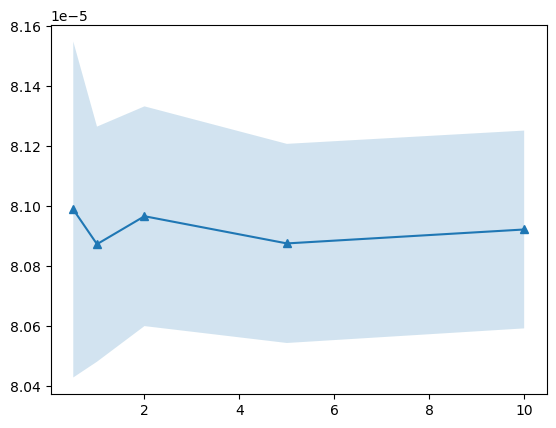

In [94]:
ci_lower = subset['confidence_interval'].apply(lambda x: eval(x)[0])  # Lower bound
ci_upper = subset['confidence_interval'].apply(lambda x: eval(x)[1])  # Upper bound
plt.plot(subset['b'], subset['mean_response_time'], marker=marker, linestyle='-', label=f"{traffic_class.capitalize()} Traffic")
plt.fill_between(subset['b'], ci_lower, ci_upper, alpha=0.2)


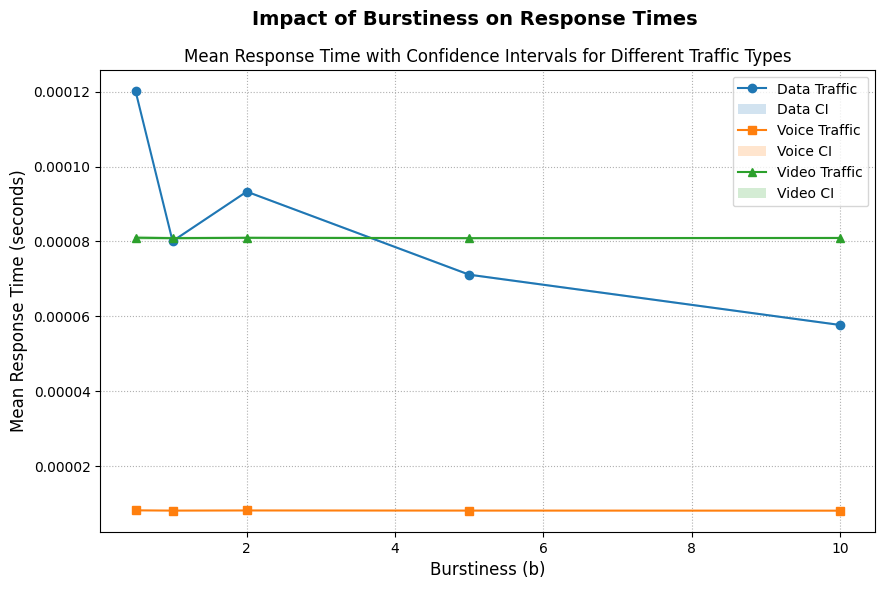

In [95]:
# Load experiment results
experiment_results = pd.read_csv("burstiness_results.csv")

# Create figure for response time vs. burstiness
plt.figure(figsize=(10, 6))

# Main title
plt.suptitle("Impact of Burstiness on Response Times", fontsize=14, fontweight='bold')

# Subtitle
plt.title("Mean Response Time with Confidence Intervals for Different Traffic Types", fontsize=12)

# Plot response times with confidence intervals
for traffic_class, marker in zip(['data', 'voice', 'video'], ['o', 's', '^']):
    subset = experiment_results[experiment_results['traffic_class'] == traffic_class]

    if not subset.empty:
        plt.plot(subset['b'], subset['mean_response_time'], marker=marker, linestyle='-', label=f"{traffic_class.capitalize()} Traffic")

        # Extract confidence intervals
        ci_lower = subset['confidence_interval'].apply(lambda x: eval(x)[0])
        ci_upper = subset['confidence_interval'].apply(lambda x: eval(x)[1])

        # Add confidence interval shading
        plt.fill_between(subset['b'], ci_lower, ci_upper, alpha=0.2, label=f"{traffic_class.capitalize()} CI")

# Labels and grid
plt.xlabel("Burstiness (b)", fontsize=12)
plt.ylabel("Mean Response Time (seconds)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='dotted')

plt.show()


In [96]:
print(df_lossRates[df_lossRates['traffic_class'] == 'video'].head())


        time traffic_class  loss_rate
58  1.124089         video        0.0
59  1.124089         video        0.0
60  1.124089         video        0.0
61  1.124089         video        0.0
62  1.124089         video        0.0
